In [314]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

from numba import njit, prange

In [359]:
class Element():
    def __init__(self, charge):
        self.charge = charge



class Molecule():
    def __init__(self, elements, internal_positions : np.ndarray, position):
        self.elements = elements
        self.internal_positions = internal_positions.astype(np.float32)
        self.n_elements = len(elements)
        assert len(internal_positions) == self.n_elements, "Number of internal positions must match number of elements."
        self.position = position

        self.start_positions = internal_positions.copy()

    def calculate_internal_relaxation_force(self):
        # calculate the force on each element due to their offset from their start position
        # this is a simple harmonic force with a spring constant of 1.0

        forces = np.zeros((self.n_elements, 2))
        for i in range(self.n_elements):
            # calculate the force on element i due to its offset from its start position
            r = self.internal_positions[i] - self.start_positions[i]
            r_mag = np.linalg.norm(r)
            if r_mag > 0.001:
                f = 1.0 * r 
                forces[i] += -f * 0.5

        return forces

class Lipid(Molecule):
    def __init__(self, constituents, position):
        # headgroup and tailgroup are lists of Element objects

        assert len(constituents) >= 2, "Lipid must have exactly two or more constituents: headgroup and tailgroup."

        assert constituents[0].charge < 0, "Headgroup must be negatively charged."
        assert constituents[-1].charge > 0, "Tailgroup must be positively charged."

        # place the internal positions in a line in a random direction in 2d
        # space them out by 0.5 nm
        internal_positions = np.zeros((len(constituents), 2))
        ang = np.random.uniform(0, 2 * np.pi)
        for i in range(len(constituents)):
            internal_positions[i, 0] = i * 0.5 * np.cos(ang)
            internal_positions[i, 1] = i * 0.5 * np.sin(ang)

        # move them so their center of mass is at the origin

        com = np.zeros((2,))
        for i in range(len(constituents)):
            com += internal_positions[i]
        com /= len(constituents)

        for i in range(len(constituents)):
            internal_positions[i] -= com

        super().__init__(constituents, internal_positions, position)

class Water(Molecule):
    def __init__(self, position):

        water = [Element(-0.1)]
        super().__init__(water, np.array([np.array([0,0])]), position)

        # water is a single element with no internal positions

class GenericLipid(Lipid):
    def __init__(self, positions):
        # a two element lipid
        # the first element is a headgroup, the second is a tailgroup
        # the headgroup is negatively charged, the tailgroup is positively charged

        headgroup = Element(-1.)
        tailgroup = Element(1.)
        constituents = [headgroup, tailgroup]
        # place the internal positions in a line in a random direction in 2d

        super().__init__(constituents, positions)


class Environment():
    def __init__(self, n_lipids, n_water):
        self.n_lipids = n_lipids
        self.n_water = n_water
        self.lipids = []
        self.waters = []

        # create the lipids and waters in random positions
        for i in range(n_lipids):
            position = np.random.uniform(-10, 10, size=(2,))
            lipid = GenericLipid(position)
            self.lipids.append(lipid)

        for i in range(n_water):
            position = np.random.uniform(-10, 10, size=(2,))
            water = Water(position)
            self.waters.append(water)

        all_molecules = self.lipids + self.waters
        self.all_molecules = all_molecules

    def unravel(self):
        # unravel the lipids and waters into a single array of positions
        # this is used for visualization

        positions = []
        charges = []
        for molecule in self.all_molecules:
            for i in range(len(molecule.elements)):
                positions.append(molecule.position + molecule.internal_positions[i])
                charges.append(molecule.elements[i].charge)

        return np.array(positions), np.array(charges)

    def ravel(self, unraveled_value):
        # ravel the positions back into the original positions
        # this is used for visualization

        raveled_value = []
        i = 0
        for molecule in self.all_molecules:
            raveled_value.append(unraveled_value[i:(i + len(molecule.elements))])
            i += len(molecule.elements)

        assert i == len(unraveled_value), "Raveling failed: not all elements were raveled."

        return raveled_value
    
    @staticmethod
    @njit(parallel=True)
    def get_forces_unraveled(unraveled_positions, unraveled_charges):
    
        # OBVIOUS TODO: Forces are symetric
        forces = np.zeros((len(unraveled_positions), 2))
        for i in prange(len(unraveled_positions)):
            position = unraveled_positions[i]
            charge = unraveled_charges[i]
            for j in range(i+1, len(unraveled_positions)):
                other_position = unraveled_positions[j]
                other_charge = unraveled_charges[j]

                # calculate the force between the two molecules
                r = other_position - position
                r_mag = np.linalg.norm(r)
                if r_mag > 10.0:
                    continue

                repel = False
                if r_mag < 1.:
                    repel = True

                if not repel:
                    f = -1. * charge * other_charge / (r_mag ** 1.)
                else:
                    f = -1. / (r_mag ** 1.)

                direction = r / r_mag

                f = f * direction
                            
                forces[i] += f * 0.1
                forces[j] -= f * 0.1

            # add small force towards the [5,5]
            forces[i] += (np.array([0,0]) - position) * 0.001

        return forces
    
    
    def step(self, dt):
        # noise step
        for molecule in self.all_molecules:
            molecule.position += np.random.normal(0, 0.01, size=(2,))

        # calculate intermolecular forces
        # forces = self.get_forces(self.all_molecules)
        unraveled_positions, unraveled_charges = self.unravel()
        unraveled_forces = self.get_forces_unraveled(unraveled_positions, unraveled_charges)
        forces = self.ravel(unraveled_forces)
        # update internal positions
        for i in range(len(self.all_molecules)):
            molecule = self.all_molecules[i]
            for j, elemenent in enumerate(molecule.elements):
                f = forces[i][j]
                molecule.internal_positions[j] += f * dt 
                
        # calculate internal relaxation forces
        for i in range(len(self.all_molecules)):
            molecule = self.all_molecules[i]
            internal_forces = molecule.calculate_internal_relaxation_force()
            for j, elemenent in enumerate(molecule.elements):
                molecule.internal_positions[j] += internal_forces[j] * dt

        # update positions of the molecules
        for i in range(len(self.all_molecules)):
            molecule = self.all_molecules[i]
            com = np.zeros((2,))
            for j in range(len(molecule.elements)):
                com += molecule.internal_positions[j]
            com /= len(molecule.elements)

            molecule.position += com
            molecule.internal_positions -= com

    def visualize(self):
        fig, ax = plt.subplots()

        self.make_vizualization(ax, self.all_molecules)

        ax.set_xlim(-15, 15)
        ax.set_ylim(-15, 15)
        ax.set_aspect('equal')
        ax.set_xlabel('x (nm)')
        ax.set_ylabel('y (nm)')
        plt.show()


    def make_vizualization(self, ax, molecules):
        for molecule in molecules:
            ax.scatter(molecule.position[0], molecule.position[1], s=100, c='k')
            for i in range(len(molecule.elements)):
                c = molecule.elements[i].charge
                ix = molecule.internal_positions[i][0] + molecule.position[0]
                iy = molecule.internal_positions[i][1] + molecule.position[1]
                ax.scatter(ix, iy, s = 50, c='r' if c < 0 else 'b')

        return ax
    
    def get_molecules(self):
        am = self.all_molecules
        # perform a deep copy of the molecules
        # this is a bit slow, but we need to do it to avoid modifying the original molecules

        return_am = []
        for molecule in am:
            new_molecule = Molecule(molecule.elements, molecule.internal_positions.copy(), molecule.position.copy())
            return_am.append(new_molecule)
        return return_am
    
    def run(self, n_steps, dt):
        for i in range(n_steps):
            self.step(dt)

            if i % 10 == 0:
                ...
                # print(f"Step {i}/{n_steps}")


        



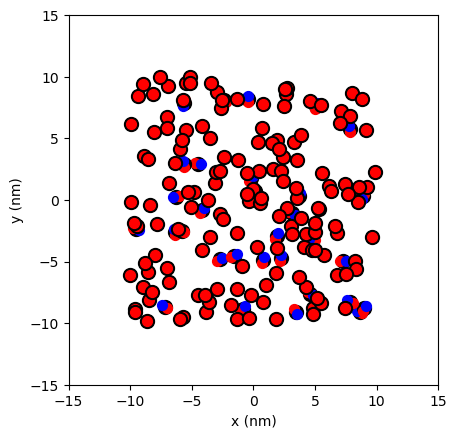

In [360]:
env = Environment(30, 150)

# env.run(100, 0.01)
env.visualize()


In [364]:
# simulate the system for 100 steps with a time step of 0.01

all_molecules = []

all_molecules.append(env.get_molecules())
for i in range(30):
    print(i, end= '\r')
    env.run(500, 0.1)
    all_molecules.append(env.get_molecules())

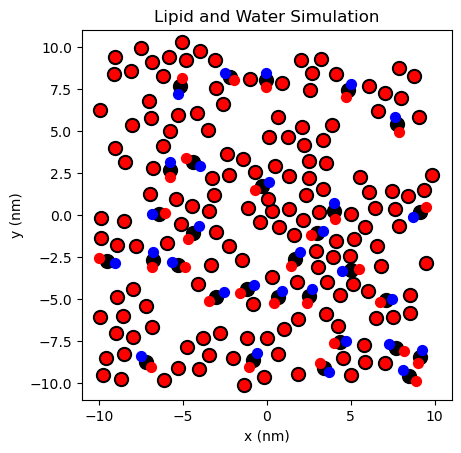

In [363]:
# imort funcanim

from matplotlib.animation import FuncAnimation
from matplotlib import rc

rc('animation', html='jshtml')
fig, ax = plt.subplots()
ax.set_xlim(-11, 11)
ax.set_ylim(-11, 11)
ax.set_aspect('equal')
ax.set_title("Lipid and Water Simulation")

ax.set_xlabel("x (nm)")
ax.set_ylabel("y (nm)")


def update(frame):
    print(frame, end="\r")
    ax.clear()
    ax.set_xlim(-11, 11)
    ax.set_ylim(-11, 11)
    ax.set_aspect('equal')
    ax.set_title("Lipid and Water Simulation")
    ax.set_xlabel("x (nm)")
    ax.set_ylabel("y (nm)")

    for molecule in all_molecules[frame]:
        ax.scatter(molecule.position[0], molecule.position[1], s=100, c='k')
        for i in range(len(molecule.elements)):
            c = molecule.elements[i].charge
            ix = molecule.internal_positions[i][0] + molecule.position[0]
            iy = molecule.internal_positions[i][1] + molecule.position[1]
            ax.scatter(ix, iy, s=50, c='r' if c < 0 else 'b')
    
    return ax

ani = FuncAnimation(fig, update, frames=len(all_molecules), interval=100, repeat=True)

# display the animation
from IPython.display import display, HTML
display(HTML(ani.to_jshtml()))

(-50.0, 50.0)

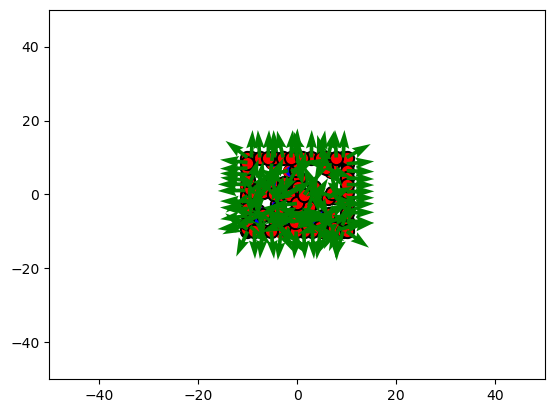

In [309]:
fig, ax = plt.subplots()
forces = env.get_forces(env.all_molecules)

env.make_vizualization(ax, env.all_molecules)
for i in range(len(env.all_molecules)):
    molecule = env.all_molecules[i]
    for j in range(len(molecule.elements)):
        f = forces[i][j]
        ax.quiver(molecule.internal_positions[j][0] + molecule.position[0], 
                  molecule.internal_positions[j][1] + molecule.position[1], 
                  f[0], f[1],  color='g')
        
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)